In [1]:
import json
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define datasets and directions
datasets = [
    "anatomy",
    "clinical_knowledge",
    "college_biology",
    "college_medicine",
    "medical_genetics",
    "medqa",
    "professional_medicine",
    # "medmcqa",
    # "pubmed_qa",
    "usmle_sa_step1",
    "usmle_sa_step2",
    "usmle_sa_step3",
    "medqa_4options_b2g",
    "usmle_sa_step1_b2g",
    "usmle_sa_step2_b2g",
    "usmle_sa_step3_b2g",
    "mmlu_anatomy_b2g",
    "mmlu_clinical_knowledge_b2g",
    "mmlu_college_medicine_b2g",
    "mmlu_medical_genetics_b2g",
    "mmlu_professional_medicine_b2g",
    "mmlu_college_biology_b2g",
    "medqa_4options_g2b",
    "usmle_sa_step1_g2b",
    "usmle_sa_step2_g2b",
    "usmle_sa_step3_g2b",
    "mmlu_anatomy_g2b",
    "mmlu_clinical_knowledge_g2b",
    "mmlu_college_medicine_g2b",
    "mmlu_medical_genetics_g2b",
    "mmlu_professional_medicine_g2b",
    "mmlu_college_biology_g2b",
]

models = [
    "microsoft/phi-1",
    "microsoft/phi-1_5",
    "microsoft/phi-2",
    "microsoft/Phi-3-mini-4k-instruct",
    "mistralai/Mistral-7B-v0.1",
    "Qwen/Qwen1.5-7B",
]

replacement_directions = ["brand_to_generic", "generic_to_brand", "none"]

## Model results


In [3]:
def load_model_results(model, direction):
    """
    Load the model results from a JSON file.

    Args:
    model (str): The model name.
    direction (str): The direction of replacements (e.g., brand_to_generic, generic_to_brand).

    Returns:
    pd.DataFrame: A DataFrame containing the model results.
    """
    results_file_path = f"b4b/{model}_results.json"

    if os.path.exists(results_file_path):
        with open(results_file_path, "r") as file:
            results_data = json.load(file)

        results = results_data["results"]
        results_list = []

        for dataset, metrics in results.items():
            for metric, value in metrics.items():
                if metric.startswith("acc"):
                    metric_name = metric.split(",")[0]
                    results_list.append([dataset, metric_name, value])

        df_results = pd.DataFrame(results_list, columns=["Dataset", "Metric", "Value"])
        df_results["Model"] = model
        df_results["Dataset"] = df_results["Dataset"]

        return df_results
    else:
        return pd.DataFrame(columns=["Dataset", "Metric", "Value", "Model"])


# Initialize an empty DataFrame to store the final results
results_df = pd.DataFrame(columns=["Dataset", "Metric", "Value", "Model"])

# replace model / with - in the model name
for i in range(len(models)):
    models[i] = models[i].replace("/", "-")

# Load and store the model results
for model in models:
    for direction in replacement_directions:
        df_model_results = load_model_results(model, direction)
        if not df_model_results.empty:
            results_df = pd.concat([results_df, df_model_results], ignore_index=True)

# Save the results to a CSV file
results_output_file_path = "all_model_results.csv"
results_df.to_csv(results_output_file_path, index=False)

print("\nModel Results DataFrame:")
print(results_df.head())


Model Results DataFrame:
            Dataset           Metric     Value            Model
0               b4b              acc  0.241285  microsoft-phi-1
1               b4b       acc_stderr  0.044347  microsoft-phi-1
2               b4b         acc_norm  0.241919  microsoft-phi-1
3               b4b  acc_norm_stderr  0.000144  microsoft-phi-1
4  b4b_mmlu_anatomy              acc  0.274074  microsoft-phi-1


/var/folders/06/cy8f7k7d5pb31b4b4fpr97z80000gn/T/ipykernel_77727/2864170248.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, df_model_results], ignore_index=True)


In [4]:
def process_results(results_df):
    # Wrangle names to get pairs
    results_df["Direction"] = results_df["Dataset"].apply(
        lambda x: (
            "brand_to_generic"
            if "b2g" in x
            else "generic_to_brand" if "g2b" in x else "none"
        )
    )

    # If _b2g, _g2b, or b4b_ in name remove it from the name
    for term in ["_b2g", "_g2b", "b4b_"]:
        results_df["Dataset"] = results_df["Dataset"].apply(
            lambda x: x.replace(term, "")
        )

    # Filter the results DataFrame to include only accuracy metrics
    results_df_filtered = results_df[results_df["Metric"] == "acc"]

    # Pivot the DataFrame to have directions as columns
    pivot_results = results_df_filtered.pivot_table(
        index=["Dataset", "Model"], columns="Direction", values="Value"
    ).reset_index()

    # Replace 'b4b' with NaN
    pivot_results.replace("b4b", np.nan, inplace=True)

    # Drop the row with NaN
    pivot_results.dropna(subset=["Dataset"], inplace=True)

    # Calculate the average for each model
    average_df = (
        pivot_results.groupby("Model")[["brand_to_generic", "generic_to_brand", "none"]]
        .mean()
        .reset_index()
    )

    # Assign the averages to 'b4b' dataset
    average_df["Dataset"] = "b4b"

    # Append the averages to the original DataFrame
    pivot_results = pd.concat([pivot_results, average_df], ignore_index=True)

    return pivot_results


processed_results = process_results(results_df)
processed_results_output_file_path = "processed_model_results.csv"
processed_results

Direction,Dataset,Model,brand_to_generic,generic_to_brand,none
0,medqa_4options,microsoft-phi-1,0.241163,0.241163,0.242734
1,medqa_4options,microsoft-phi-1_5,0.311862,0.313433,0.317361
2,mmlu_anatomy,microsoft-phi-1,0.281481,0.281481,0.274074
3,mmlu_anatomy,microsoft-phi-1_5,0.259259,0.259259,0.400000
4,mmlu_clinical_knowledge,microsoft-phi-1,0.271698,0.279245,0.241509
5,mmlu_clinical_knowledge,microsoft-phi-1_5,0.275472,0.279245,0.433962
6,mmlu_college_biology,microsoft-phi-1,0.277778,0.263889,0.291667
7,mmlu_college_biology,microsoft-phi-1_5,0.194444,0.201389,0.368056
8,mmlu_college_medicine,microsoft-phi-1,0.277457,0.289017,0.213873
9,mmlu_college_medicine,microsoft-phi-1_5,0.208092,0.202312,0.387283


## Visualise difference in performance


In [5]:
# Calculate the differences
processed_results["Diff_brand_to_generic"] = (
    processed_results["brand_to_generic"] - processed_results["none"]
)
processed_results["Diff_generic_to_brand"] = (
    processed_results["generic_to_brand"] - processed_results["none"]
)

# Melt the DataFrame for plotting
melted_results = processed_results.melt(
    id_vars=["Dataset", "Model"],
    value_vars=["Diff_brand_to_generic", "Diff_generic_to_brand"],
    var_name="Direction",
    value_name="Accuracy Difference",
)

melted_results

,Dataset,Model,Direction,Accuracy Difference
0,medqa_4options,microsoft-phi-1,Diff_brand_to_generic,-0.001571
1,medqa_4options,microsoft-phi-1_5,Diff_brand_to_generic,-0.005499
2,mmlu_anatomy,microsoft-phi-1,Diff_brand_to_generic,0.007407
3,mmlu_anatomy,microsoft-phi-1_5,Diff_brand_to_generic,-0.140741
4,mmlu_clinical_knowledge,microsoft-phi-1,Diff_brand_to_generic,0.030189
5,mmlu_clinical_knowledge,microsoft-phi-1_5,Diff_brand_to_generic,-0.158491
6,mmlu_college_biology,microsoft-phi-1,Diff_brand_to_generic,-0.013889
7,mmlu_college_biology,microsoft-phi-1_5,Diff_brand_to_generic,-0.173611
8,mmlu_college_medicine,microsoft-phi-1,Diff_brand_to_generic,0.063584
9,mmlu_college_medicine,microsoft-phi-1_5,Diff_brand_to_generic,-0.179191


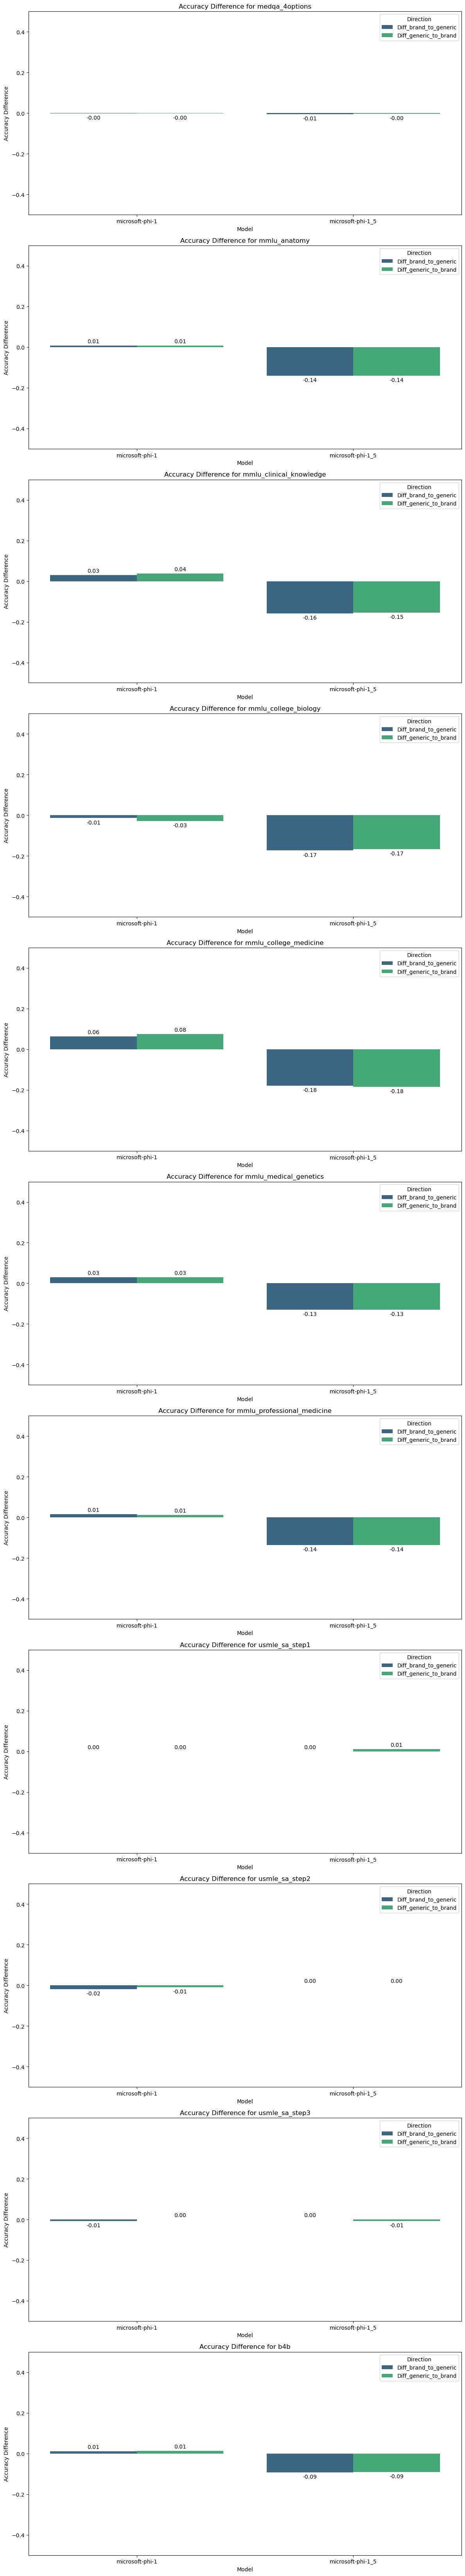

In [6]:
# Create bar plots for each task
tasks = melted_results["Dataset"].unique()
num_tasks = len(tasks)
fig, axes = plt.subplots(nrows=num_tasks, ncols=1, figsize=(12, num_tasks * 6))

for i, task in enumerate(tasks):
    ax = axes[i] if num_tasks > 1 else axes
    sns.barplot(
        x="Model",
        y="Accuracy Difference",
        hue="Direction",
        data=melted_results[melted_results["Dataset"] == task],
        palette="viridis",
        ax=ax,
    )

    # Add labels on top of the bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3)

    ax.set_title(f"Accuracy Difference for {task}")
    ax.set_xlabel("Model")
    ax.set_ylabel("Accuracy Difference")
    ax.legend(title="Direction")
    ax.set_ylim(-0.5, 0.5)  # Adjust the y-axis limits as needed

plt.tight_layout()
plt.show()

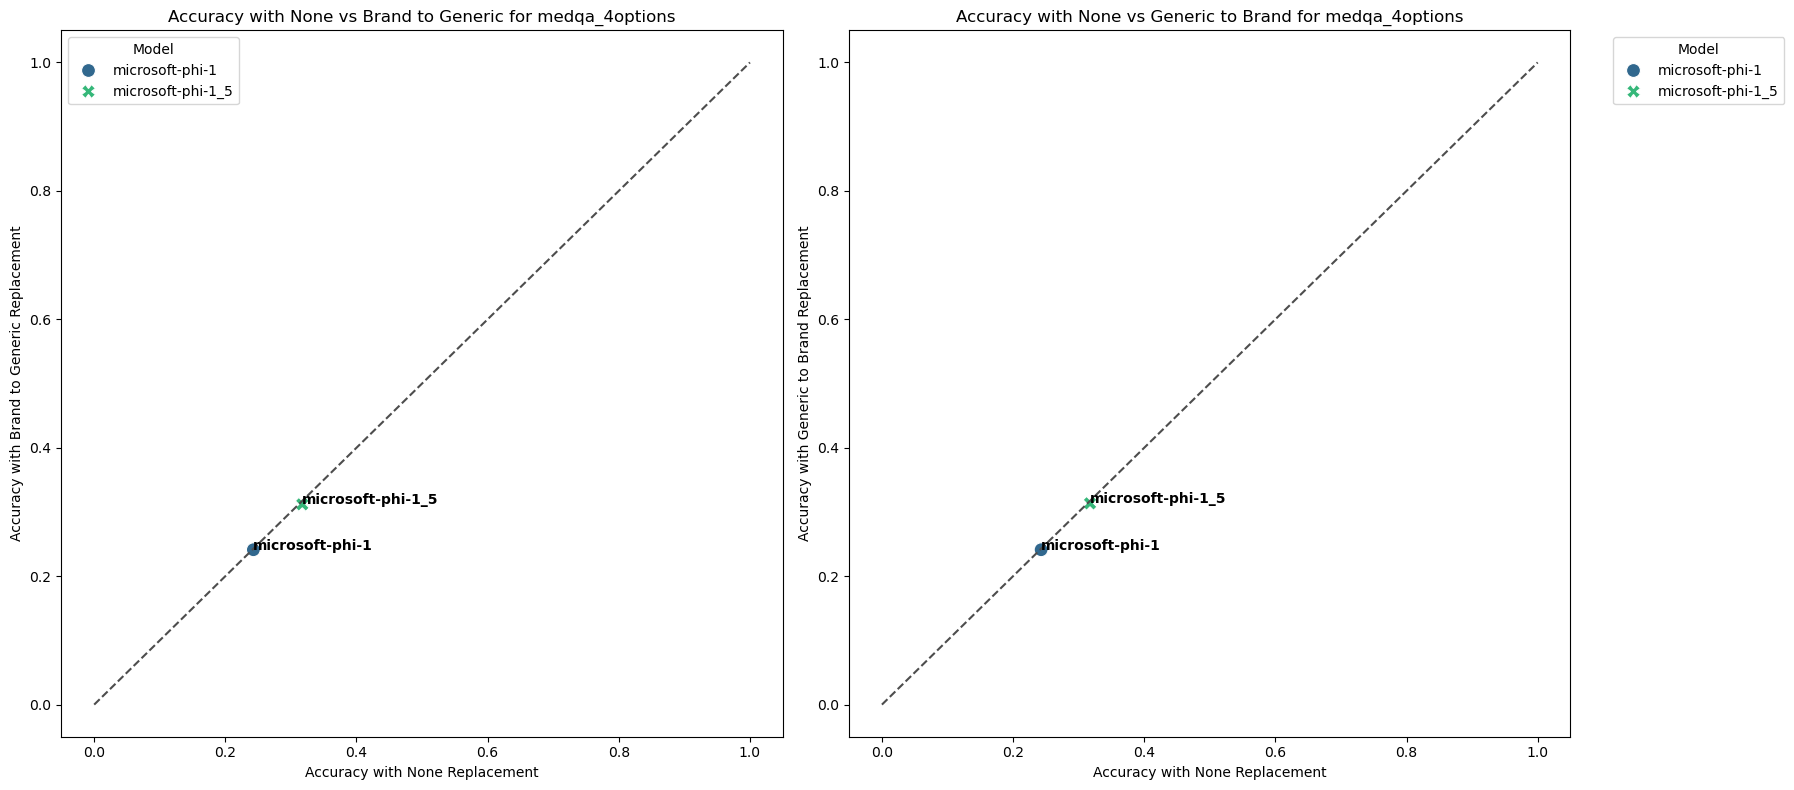

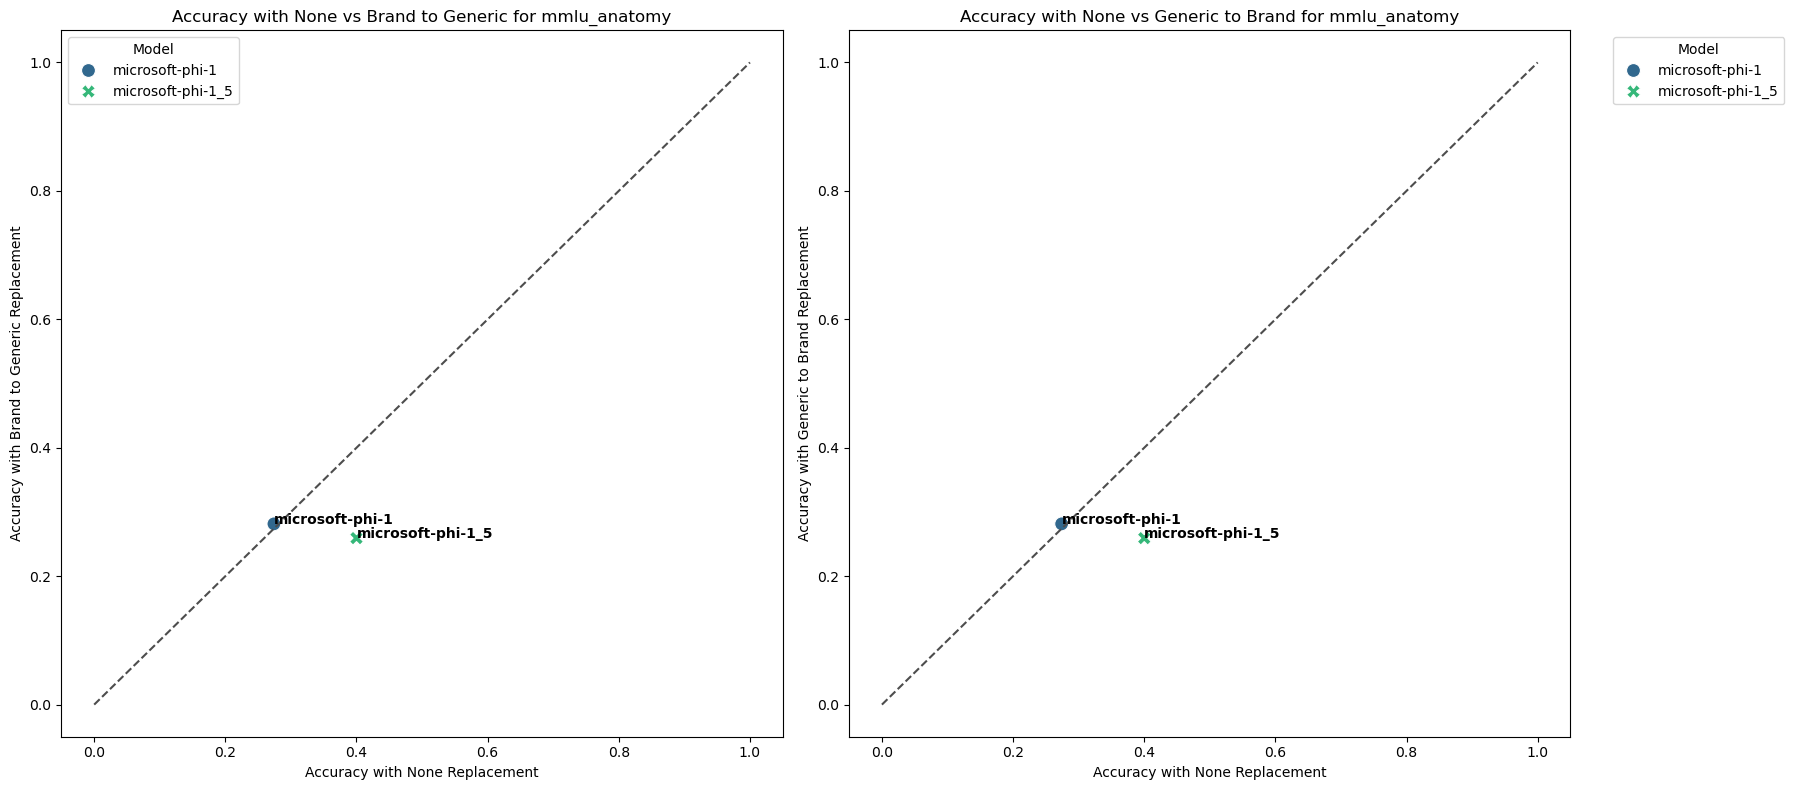

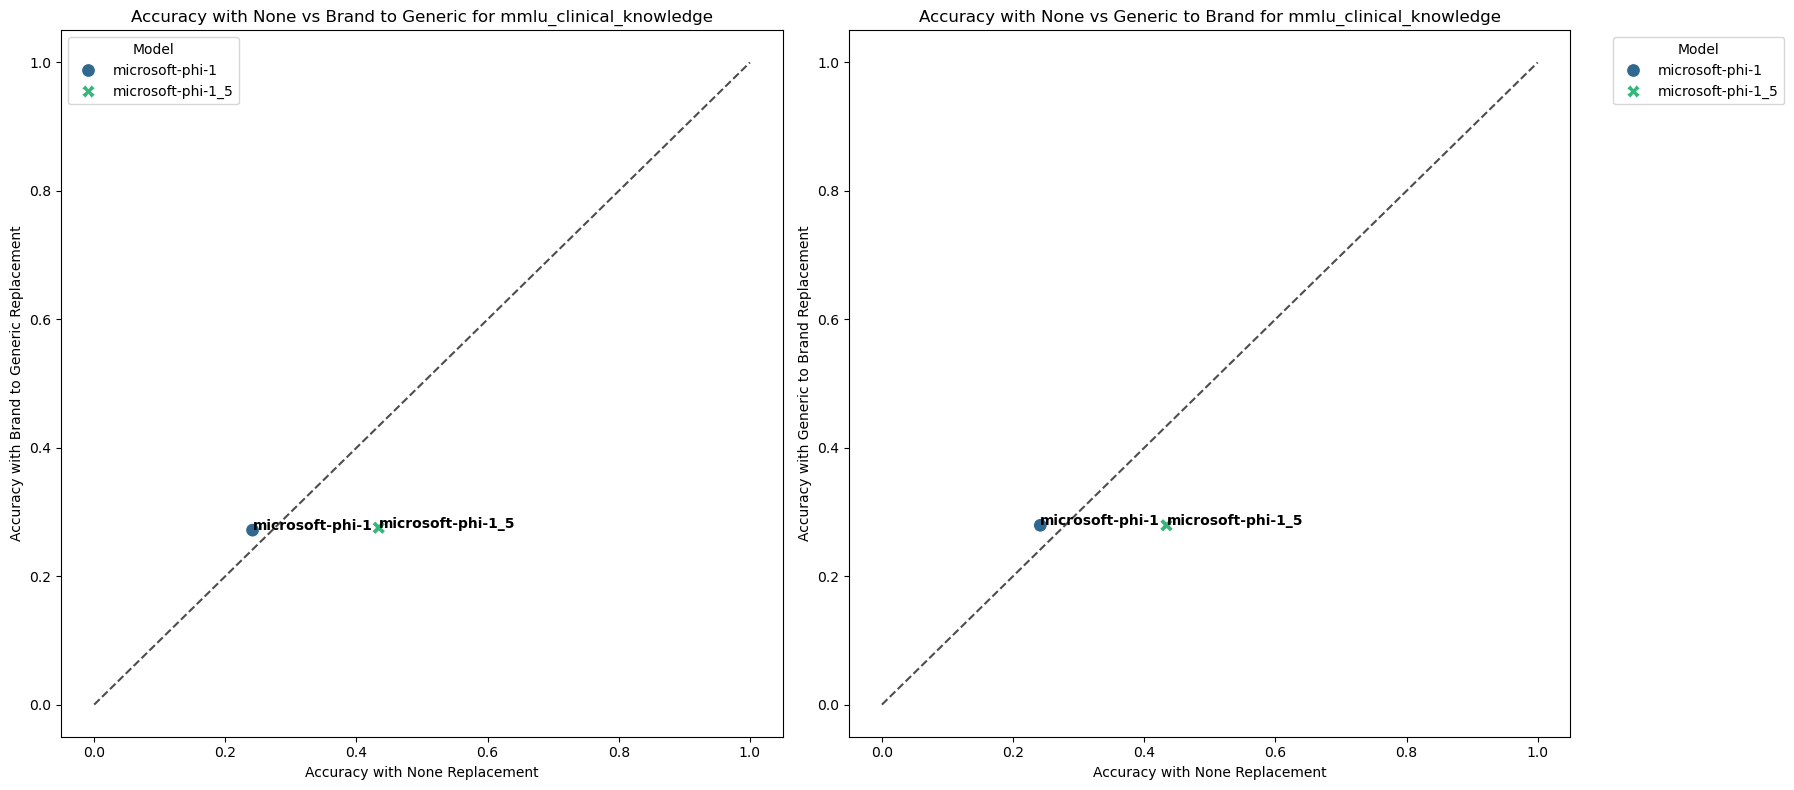

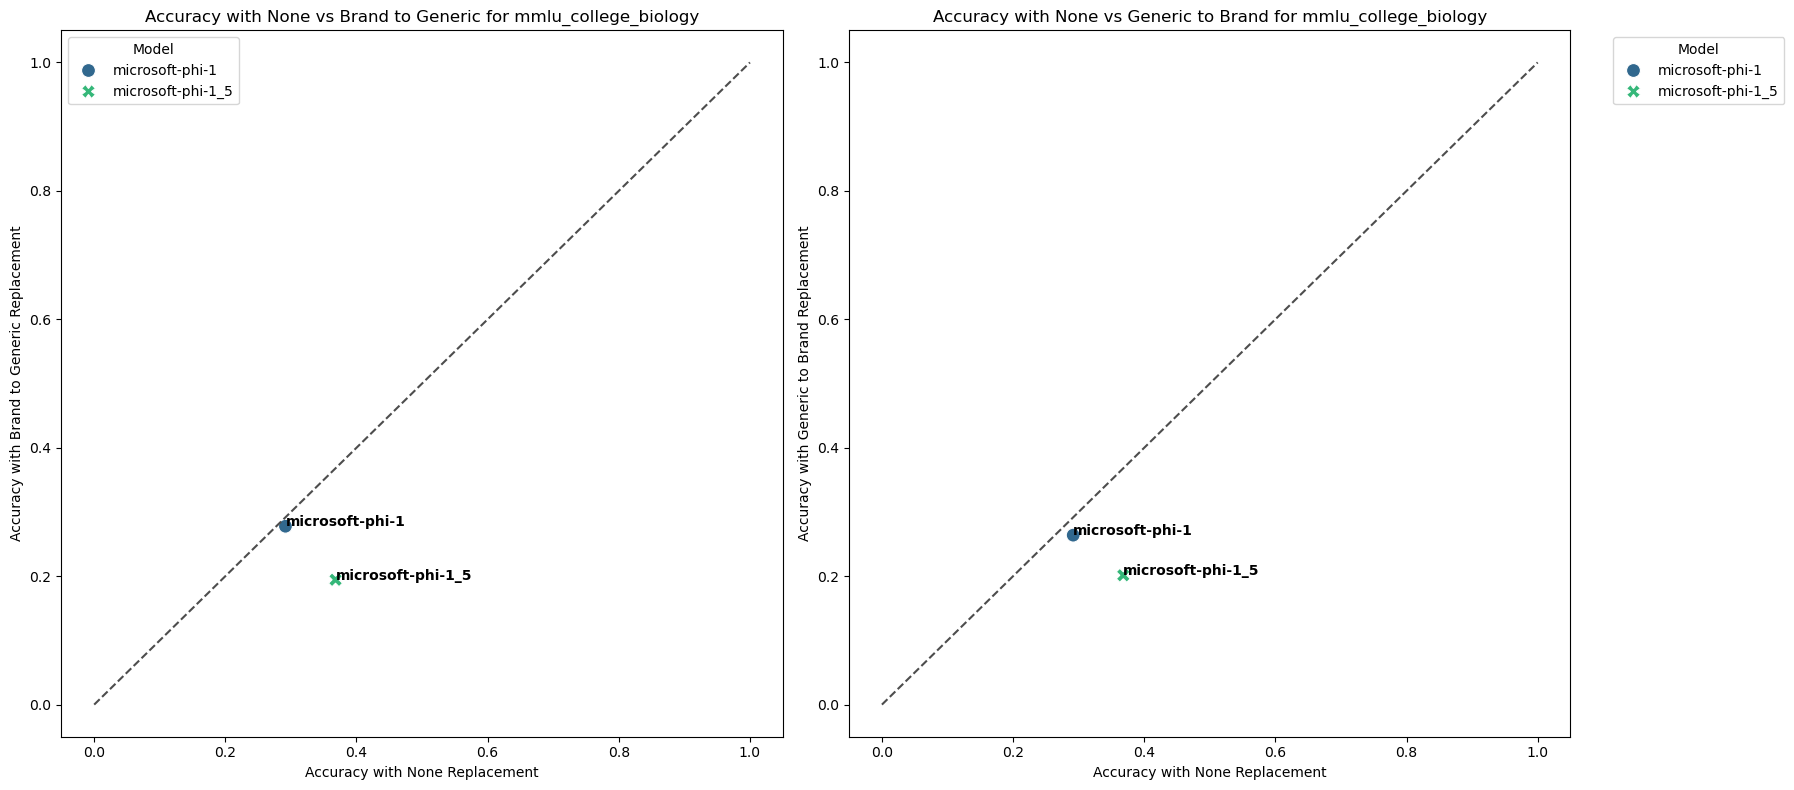

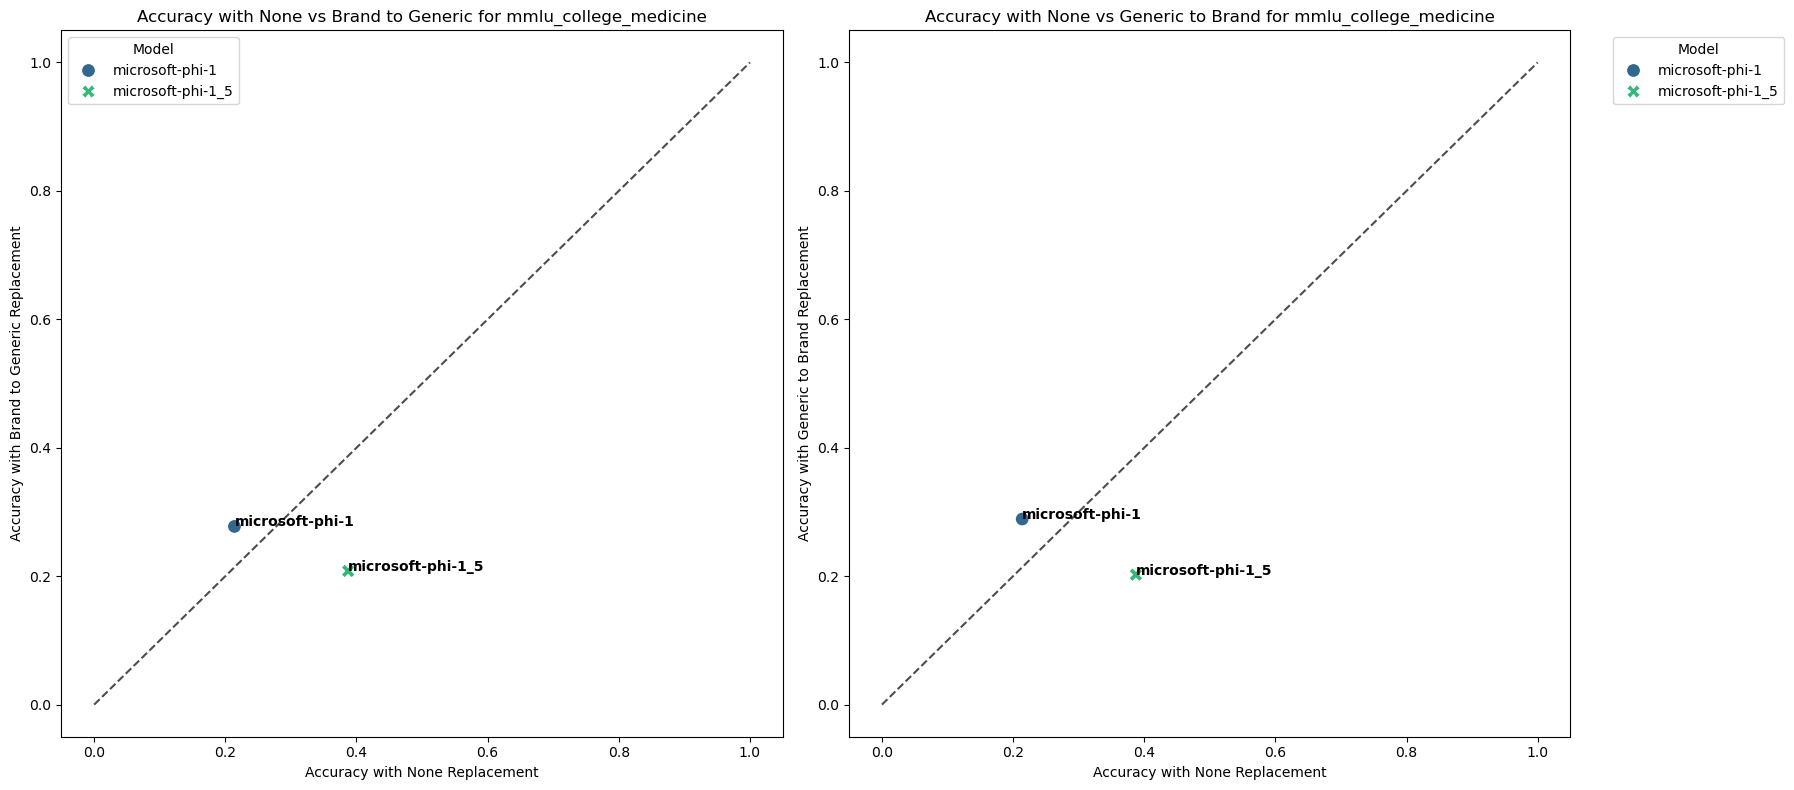

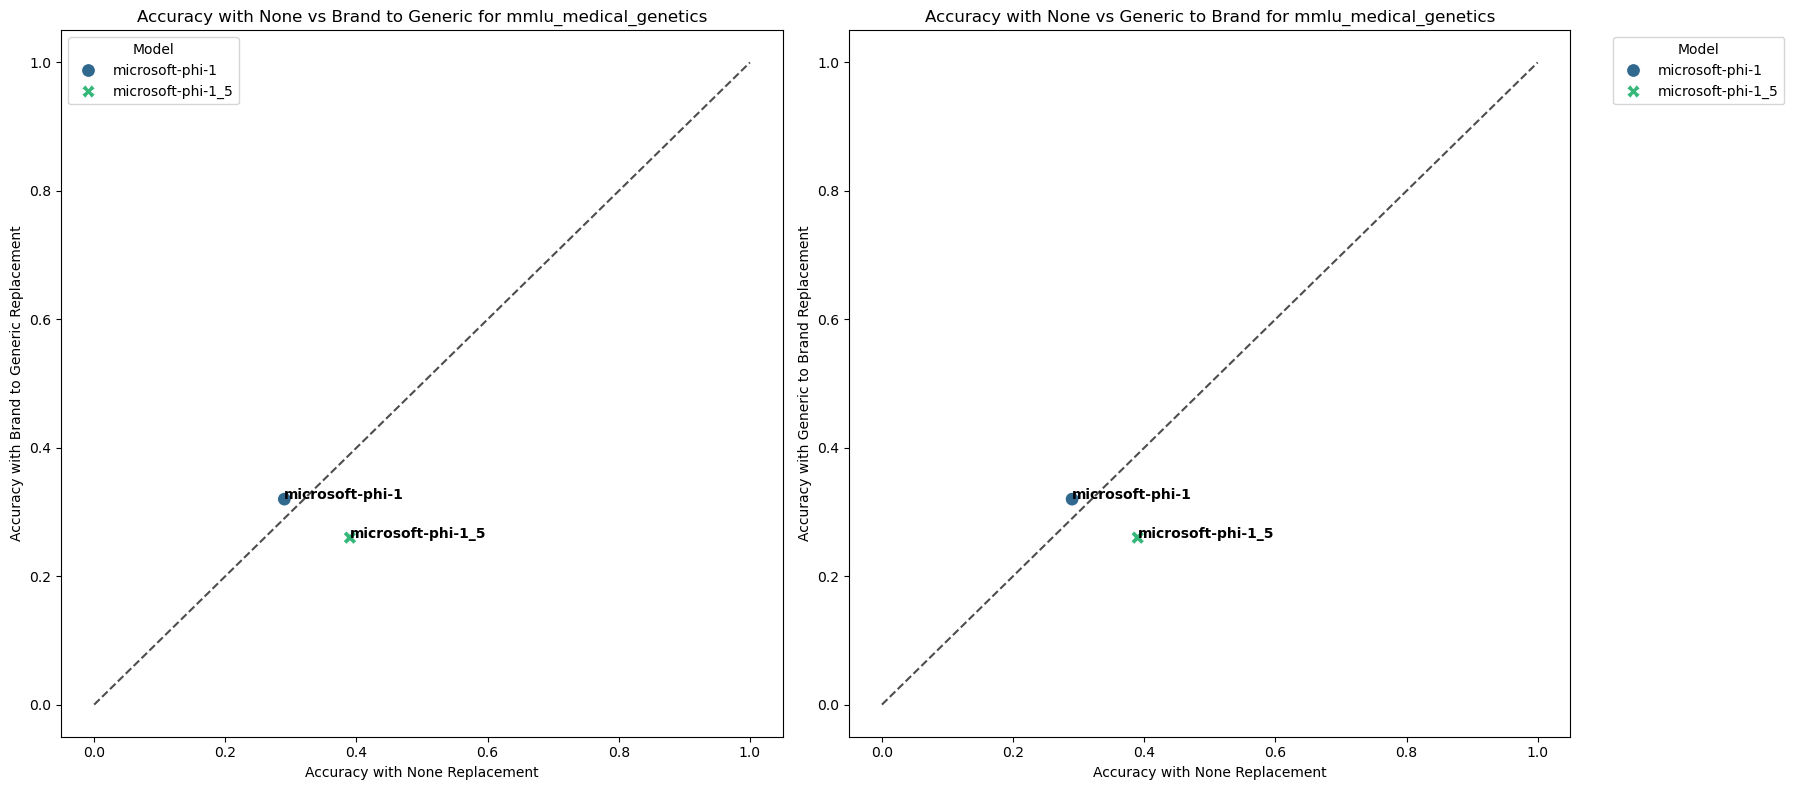

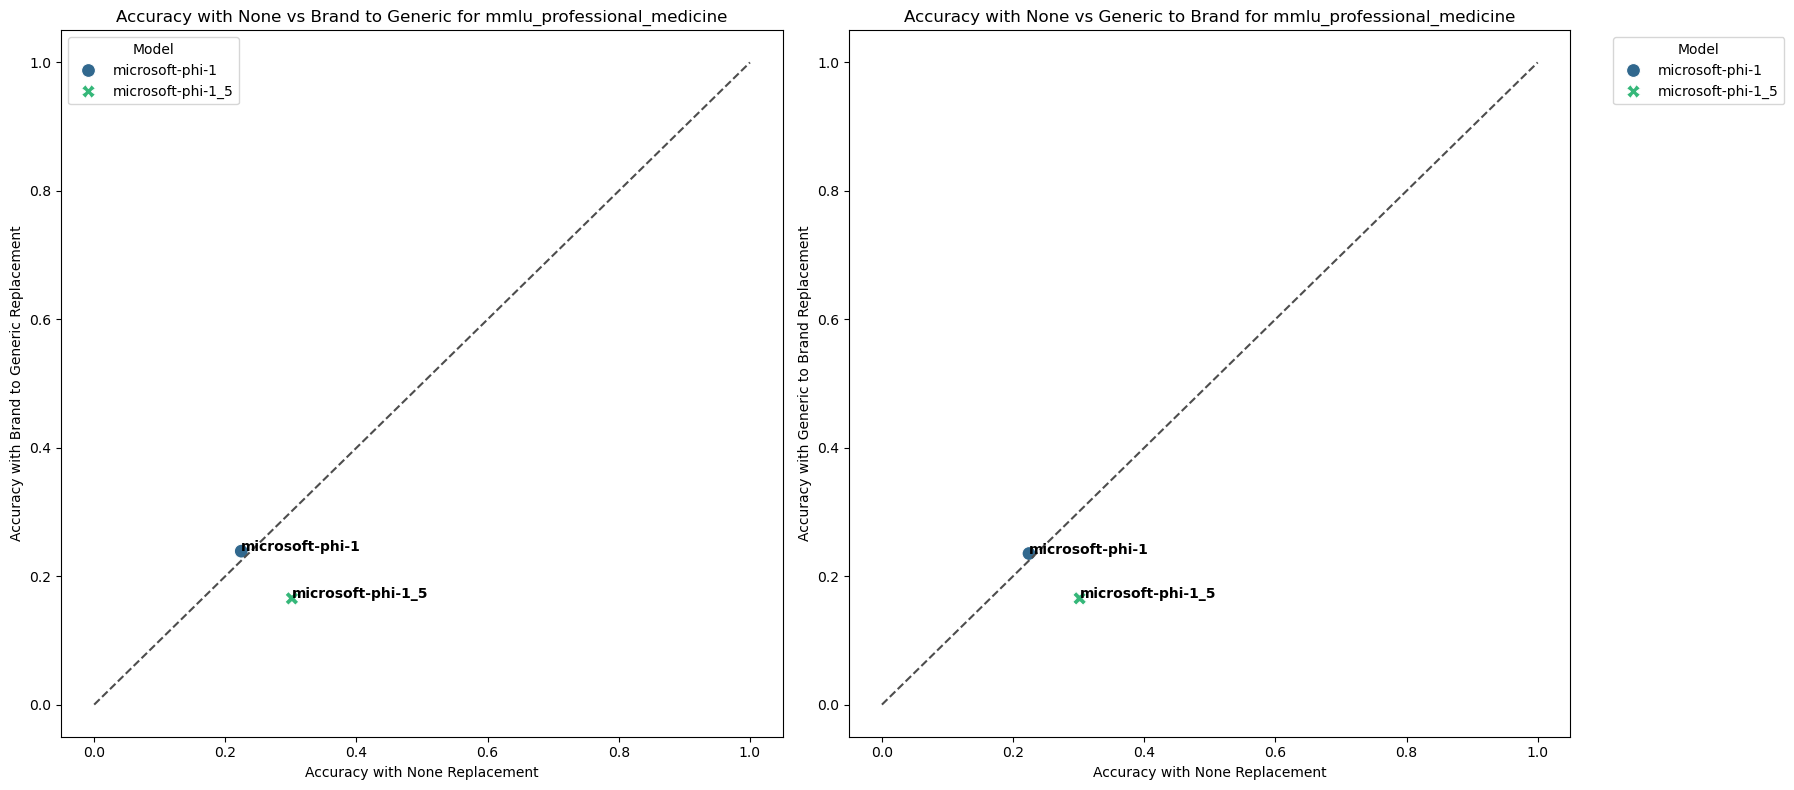

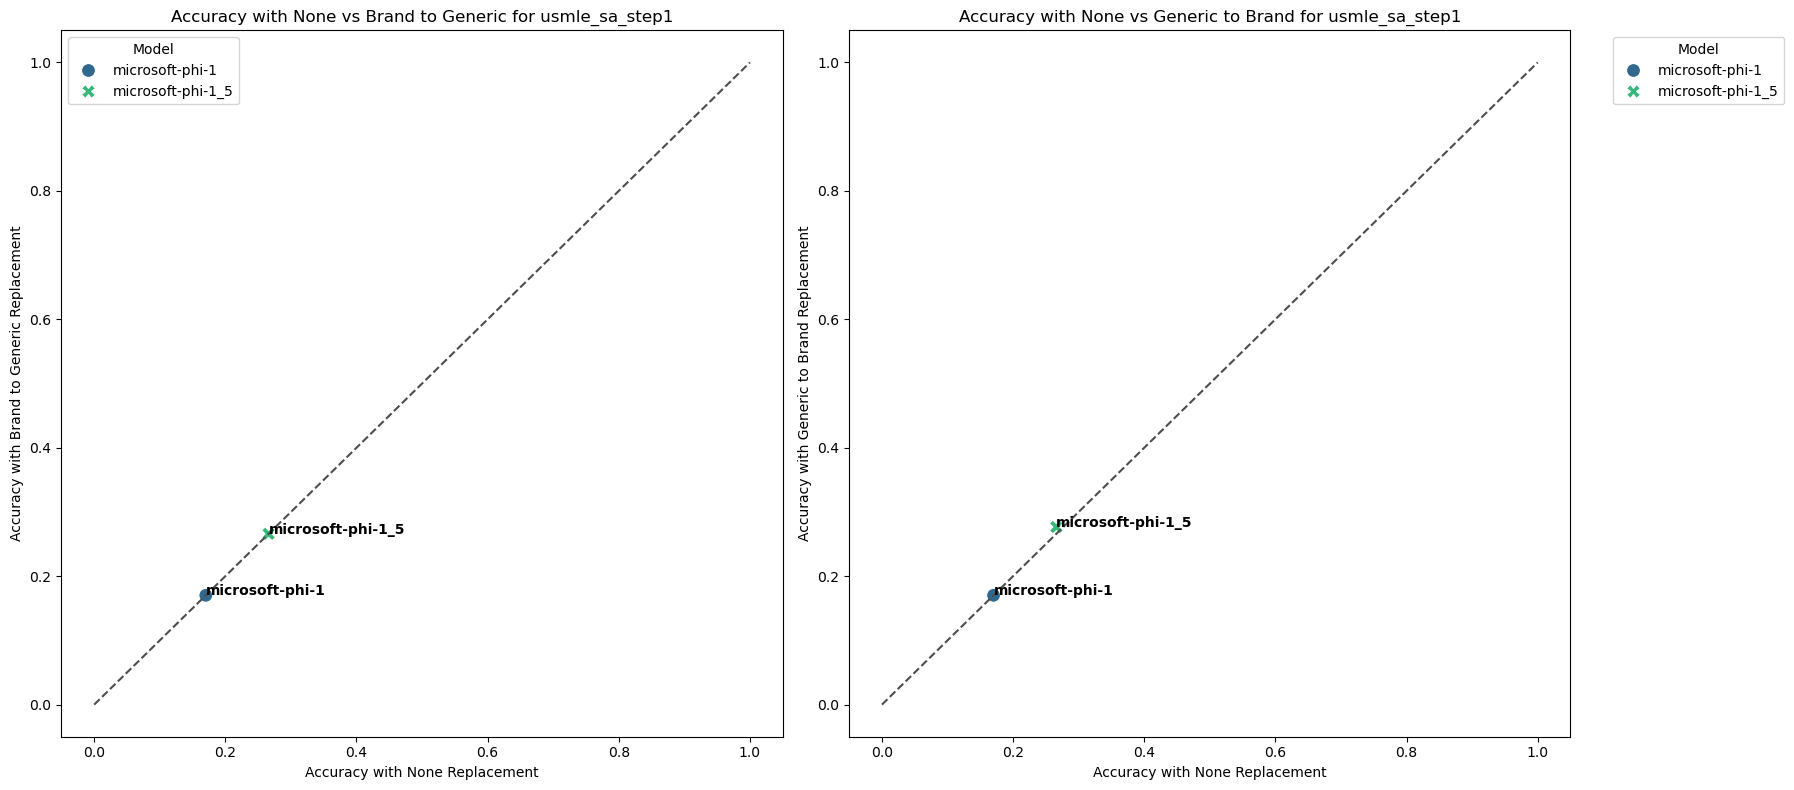

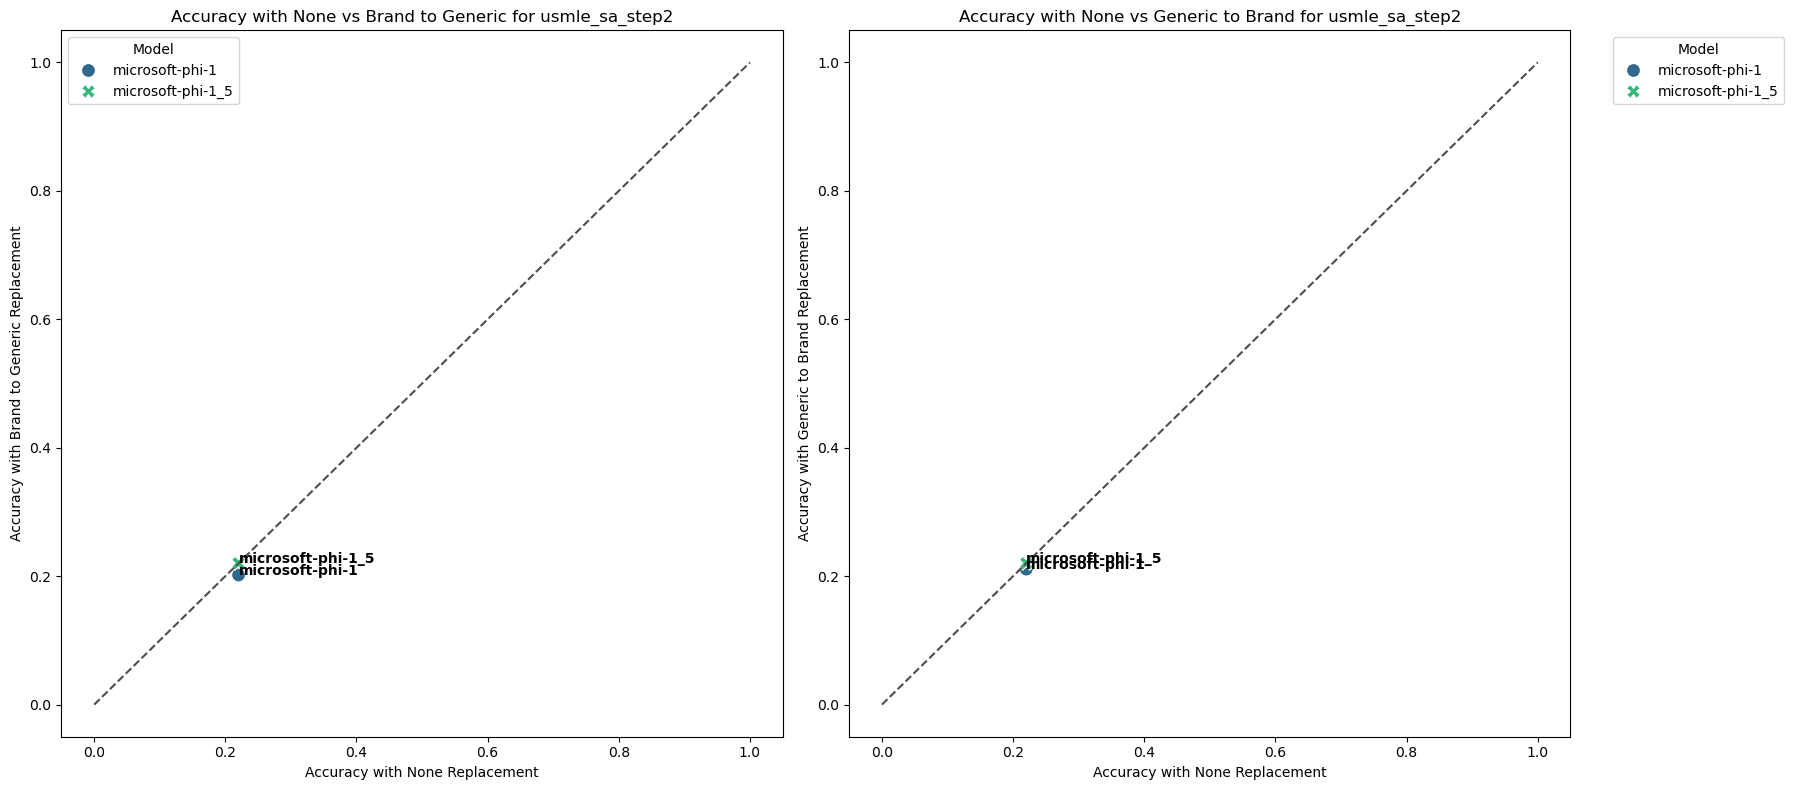

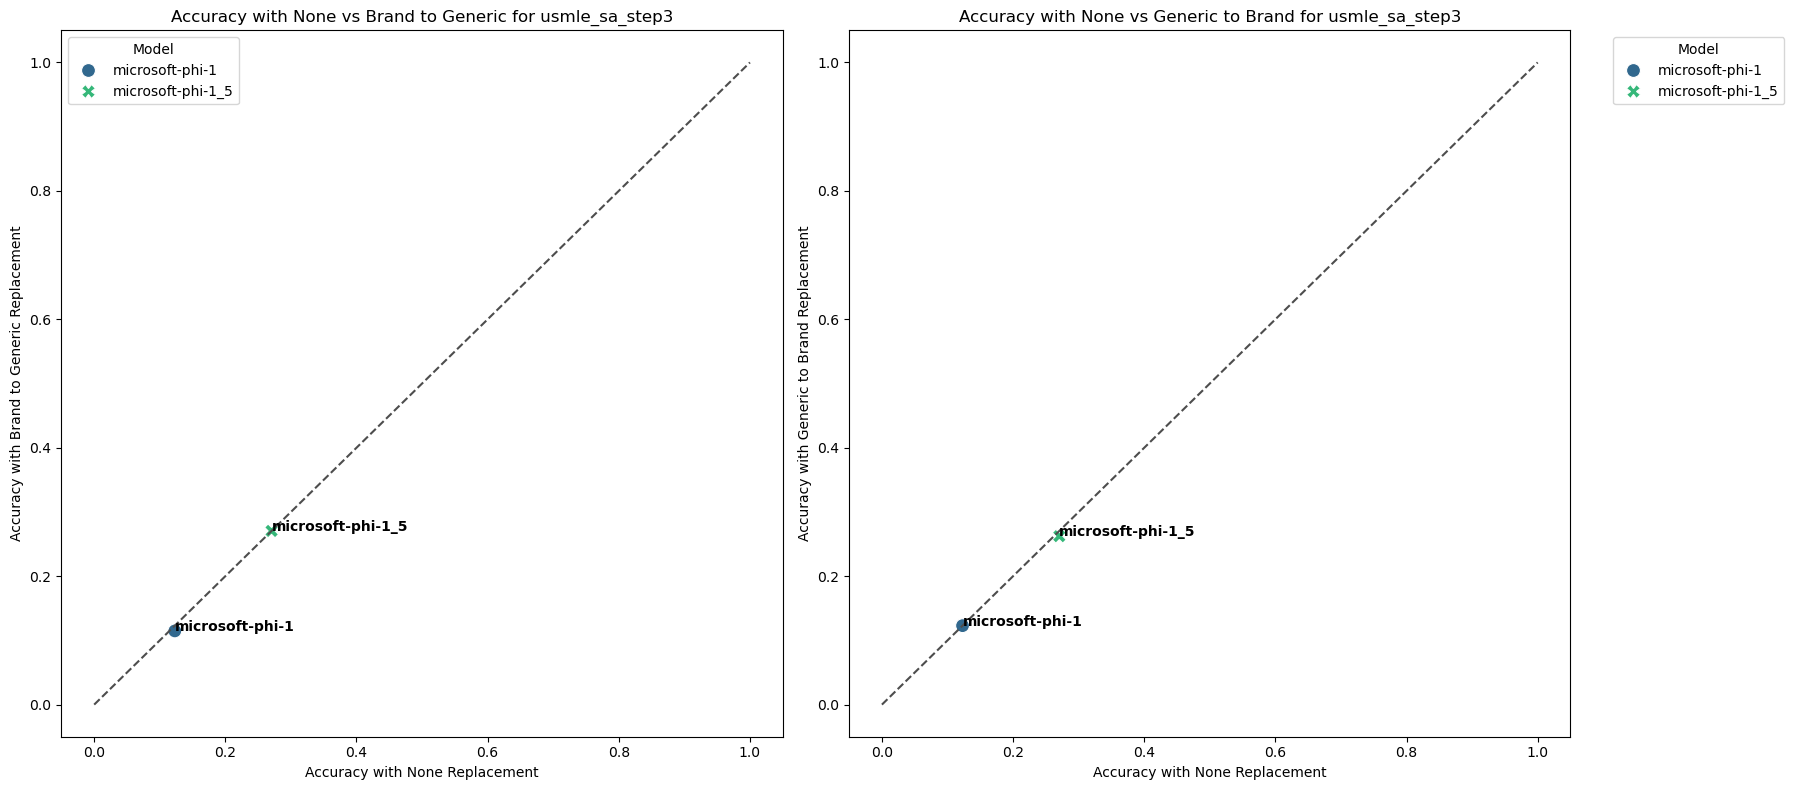

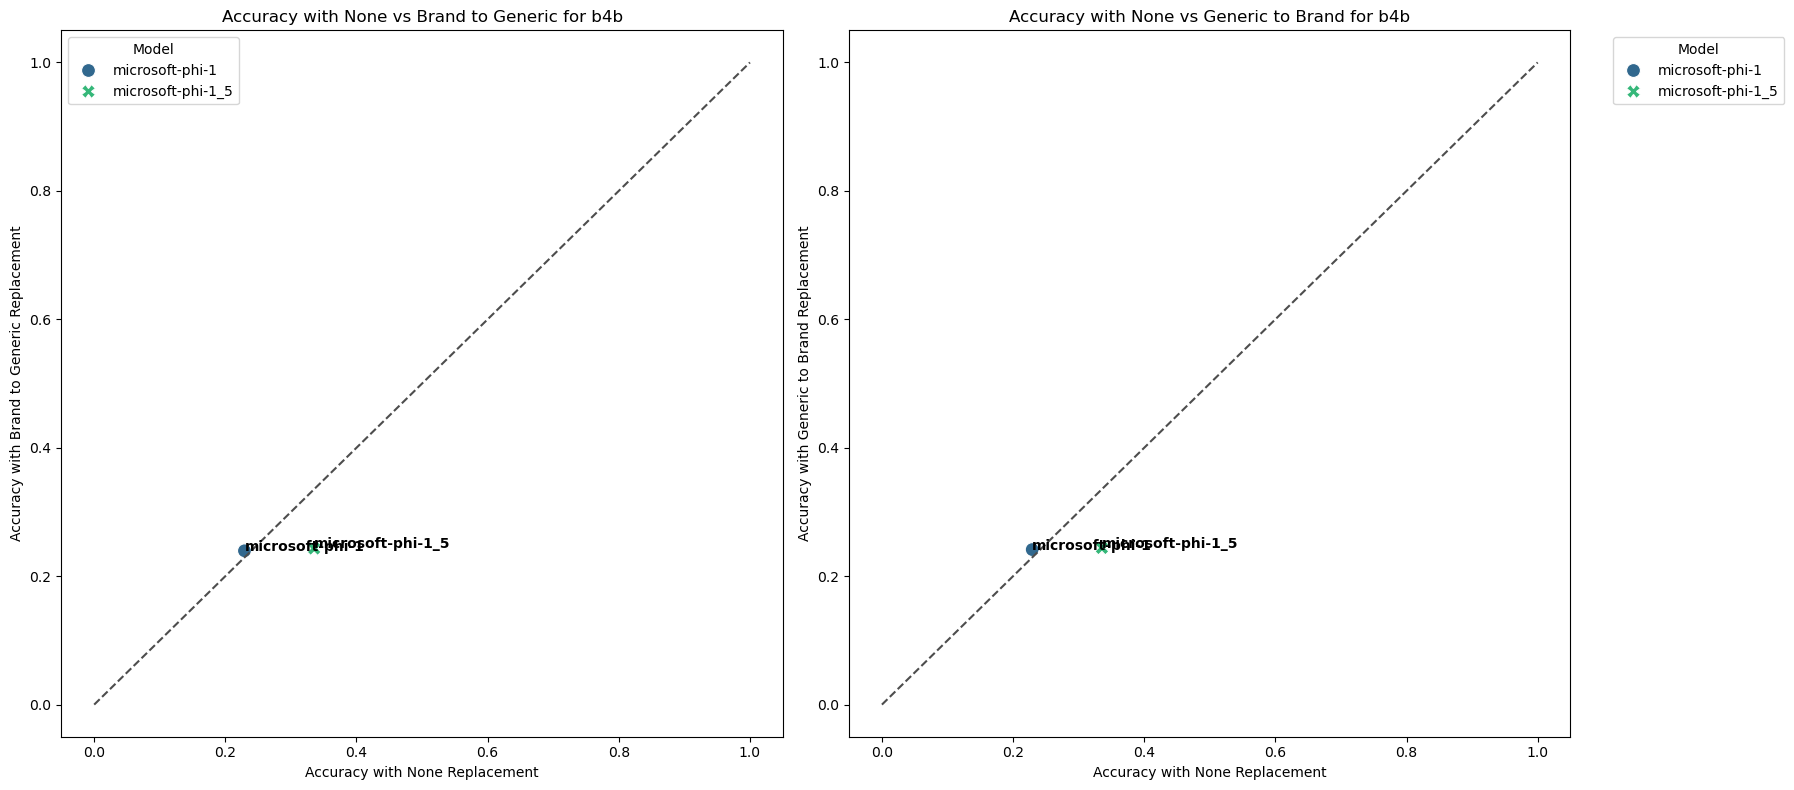

In [6]:
# Get the unique tasks
tasks = processed_results["Dataset"].unique()

# Create scatter plots for each task
for task in tasks:
    task_data = processed_results[processed_results["Dataset"] == task]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

    # Scatter plot for brand_to_generic
    sns.scatterplot(
        data=task_data,
        x="none",
        y="brand_to_generic",
        hue="Model",
        style="Model",
        palette="viridis",
        s=100,
        ax=axes[0],
    )
    for line in range(0, task_data.shape[0]):
        axes[0].text(
            task_data["none"].iloc[line],
            task_data["brand_to_generic"].iloc[line],
            task_data["Model"].iloc[line],
            horizontalalignment="left",
            size="medium",
            color="black",
            weight="semibold",
        )
    axes[0].plot([0, 1], [0, 1], ls="--", c=".3")  # Diagonal line
    axes[0].set_title(f"Accuracy with None vs Brand to Generic for {task}")
    axes[0].set_xlabel("Accuracy with None Replacement")
    axes[0].set_ylabel("Accuracy with Brand to Generic Replacement")

    # Scatter plot for generic_to_brand
    sns.scatterplot(
        data=task_data,
        x="none",
        y="generic_to_brand",
        hue="Model",
        style="Model",
        palette="viridis",
        s=100,
        ax=axes[1],
    )
    for line in range(0, task_data.shape[0]):
        axes[1].text(
            task_data["none"].iloc[line],
            task_data["generic_to_brand"].iloc[line],
            task_data["Model"].iloc[line],
            horizontalalignment="left",
            size="medium",
            color="black",
            weight="semibold",
        )
    axes[1].plot([0, 1], [0, 1], ls="--", c=".3")  # Diagonal line
    axes[1].set_title(f"Accuracy with None vs Generic to Brand for {task}")
    axes[1].set_xlabel("Accuracy with None Replacement")
    axes[1].set_ylabel("Accuracy with Generic to Brand Replacement")

    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()